# All Time TED Talks Analysis

## Individual  Project 3

<font size=4>__DATS 6013(O10)   -   Zhiyuan Tao   -   G45055489__

<font size=3>__motivations:__
    
The TED conferences, LLC was born with the initial of fields "Technology, Entertainment, and Design" and now it extends to almost all the fields. English teachers always ask us to learn English by watching TED talks. Professors will recommend us to obtain new insights, and I may also find my favorite scholars have delivered TED talks.

The most valuable thing is that the successful speakers condense their half-life research, experience and share with us in several minutes.

Since there already 4000+ talks, the data is big enough for us to analysize and find some useful information.

   
__The main objectives of this project are:__
1. Show the most popular talks, topics.
2. Realize the development of the TED platform.
3. Try to find some commonality within a talk topic, that talkers are always discussing about.
4. Build a recommendation system for users to find interesting talks.

https://jerrytaohz.github.io/Proj3pages/

# Data Preprocessing

In [1]:
# pip install yellowbrick
# pip install wordcloud

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# for data preprocessing
import ast

# for text analysis
from sklearn.feature_extraction import text

In [3]:
import os
import warnings
warnings.filterwarnings('ignore')

In [4]:
import plotly.graph_objects as go
import plotly.express as px

In [5]:
from wordcloud import WordCloud, STOPWORDS
from collections import Counter

In [6]:
import re
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [7]:
# import datetime # seems not necessary

### source of data
TED - Ultimate Dataset  
https://www.kaggle.com/miguelcorraljr/ted-ultimate-dataset

TED scraper  
https://github.com/corralm/TEDscraper

all the 4000+ talks from the first online publishment date 2006-06-27 to 2020-04-27

In [8]:
df = pd.read_csv("ted_talks_en.csv")
ted = df.drop(['transcript'], axis=1)
ted.columns

Index(['talk_id', 'title', 'speaker_1', 'all_speakers', 'occupations',
       'about_speakers', 'views', 'recorded_date', 'published_date', 'event',
       'native_lang', 'available_lang', 'comments', 'duration', 'topics',
       'related_talks', 'url', 'description'],
      dtype='object')

In [9]:
ted.head(1)

talk_id                        title speaker_1    all_speakers  \
0        1  Averting the climate crisis   Al Gore  {0: 'Al Gore'}   

                 occupations  \
0  {0: ['climate advocate']}   

                                      about_speakers    views recorded_date  \
0  {0: 'Nobel Laureate Al Gore focused the world’...  3523392    2006-02-25   

  published_date    event native_lang  \
0     2006-06-27  TED2006          en   

                                      available_lang  comments  duration  \
0  ['ar', 'bg', 'cs', 'de', 'el', 'en', 'es', 'fa...     272.0       977   

                                              topics  \
0  ['alternative energy', 'cars', 'climate change...   

                                       related_talks  \
0  {243: 'New thinking on the climate crisis', 54...   

                                                 url  \
0  https://www.ted.com/talks/al_gore_averting_the...   

                                         description  
0  With the same humor and humanity he exuded in ...

In [10]:
#pd.options.display.max_rows = 100

In [11]:
ted['recorded_date'].iloc[3831]

nan

In [12]:
ted['recorded_date'].iloc[3831] = '2019-08-01'

In [13]:
ted['recorded_date'].iloc[3831]

'2019-08-01'

In [14]:
# duration from second to mins

In [15]:
ted['duration_min']=ted['duration']/60
ted['duration_min']=ted['duration_min'].astype(float)
ted['duration_min']=ted['duration_min'].round(decimals=2)
ted = ted.drop(['duration'], axis=1)

In [16]:
ted.head(1)

talk_id                        title speaker_1    all_speakers  \
0        1  Averting the climate crisis   Al Gore  {0: 'Al Gore'}   

                 occupations  \
0  {0: ['climate advocate']}   

                                      about_speakers    views recorded_date  \
0  {0: 'Nobel Laureate Al Gore focused the world’...  3523392    2006-02-25   

  published_date    event native_lang  \
0     2006-06-27  TED2006          en   

                                      available_lang  comments  \
0  ['ar', 'bg', 'cs', 'de', 'el', 'en', 'es', 'fa...     272.0   

                                              topics  \
0  ['alternative energy', 'cars', 'climate change...   

                                       related_talks  \
0  {243: 'New thinking on the climate crisis', 54...   

                                                 url  \
0  https://www.ted.com/talks/al_gore_averting_the...   

                                         description  duration_min  
0  With the same humor and humanity he exuded in ...         16.28

In [17]:
#pd.options.display.max_rows = 100
#pd.set_option('max_colwidth',50)

## Numerical Properties

In [18]:
ted.describe()

talk_id         views     comments  duration_min
count   4005.000000  4.005000e+03  3350.000000   4005.000000
mean   12432.538327  2.148006e+06   161.997015     12.066871
std    17447.576262  3.451226e+06   268.838922      6.029596
min        1.000000  0.000000e+00     0.000000      1.000000
25%     1252.000000  8.820690e+05    38.000000      6.550000
50%     2333.000000  1.375508e+06    89.000000     12.300000
75%    23777.000000  2.133110e+06   188.000000     16.230000
max    62794.000000  6.505195e+07  6449.000000     65.370000

In [19]:
ted[['views', 'comments','duration_min']].corr()

views  comments  duration_min
views         1.000000  0.500748      0.073656
comments      0.500748  1.000000      0.175250
duration_min  0.073656  0.175250      1.000000

## most popular talks by views, comments, view/comments

In [20]:
def get_top10(feature):
    popular_talks = ted.sort_values(
                        by=feature,ascending=False).set_index(feature).reset_index().head(10)
    return popular_talks

In [21]:
# discussion rate
ted['dis_rate'] = ted['comments']/ted['views']

In [22]:
def get_top10(feature):
    popular_talks = ted[['title','speaker_1','views','comments','duration_min',
                        'recorded_date','topics', 'dis_rate']].sort_values(
                        by=feature,ascending=False).set_index(feature).reset_index().head(10)
    return popular_talks

In [23]:
pd.set_option('max_colwidth',50)
#get_top10('views')

In [24]:
#get_top10('comments')

In [25]:
#get_top10('dis_rate')

In [26]:
fig = px.bar(get_top10('views').sort_values('views'), x='views', y='title',# orientation='h',
            hover_data=["speaker_1", "comments","recorded_date",'topics'],
            title='top 10 views')

fig.update_layout(xaxis_tickfont_size=14)
fig.update_layout(yaxis_tickfont_size=16)
#fig.update_layout(uniformtext_minsize=30)#, uniformtext_mode='hide')
fig.show()

In [27]:
fig = px.bar(get_top10('comments').sort_values('comments'), x='comments', y='title',# orientation='h',
            hover_data=["speaker_1", "comments","recorded_date",'topics'],
            #height=300,
            title='top 10 comments')

fig.update_layout(xaxis_tickfont_size=14)
fig.update_layout(yaxis_tickfont_size=16)
fig.show()

In [28]:
fig = px.bar(get_top10('dis_rate').sort_values('dis_rate'), x='dis_rate', y='title',# orientation='h',
            hover_data=["speaker_1", "comments","recorded_date",'topics'],
            #height=300,
            title='top 10 discussion rate')
fig.update_layout(xaxis_tickfont_size=14)
fig.update_layout(yaxis_tickfont_size=16)
fig.show()

##  Number of talks by year

In [29]:
months = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6, 'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}

month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
day_order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

In [30]:
ted['year'] = ted['recorded_date'].apply(lambda x: x.split('-')[0])
year_df = pd.DataFrame(ted['year'].value_counts().reset_index())
year_df.columns = ['year', 'talks']
year_df = year_df.sort_values(by='year', ascending=True)

In [31]:
# drop '2020' since it's not complete
fig = go.Figure(go.Scatter(x=year_df['year'][:-1], y=year_df['talks'][:-1], mode='lines+markers'))
fig.show()

In [32]:
hmap_df = ted.copy()
hmap_df['recorded_date'] = hmap_df['recorded_date'].apply(lambda x: month_order[int(x.split('-')[1]) - 1] + " " + str(x.split('-')[0]))
hmap_df = pd.pivot_table(hmap_df[['recorded_date', 'title']], index='recorded_date', aggfunc='count').reset_index()
hmap_df['month_num'] = hmap_df['recorded_date'].apply(lambda x: months[x.split()[0]])
hmap_df['year'] = hmap_df['recorded_date'].apply(lambda x: x.split()[1])
hmap_df = hmap_df.sort_values(['year', 'month_num'])
hmap_df = hmap_df[['month_num', 'year', 'title']]
hmap_df = hmap_df.pivot('month_num', 'year', 'title')
hmap_df = hmap_df.fillna(0)

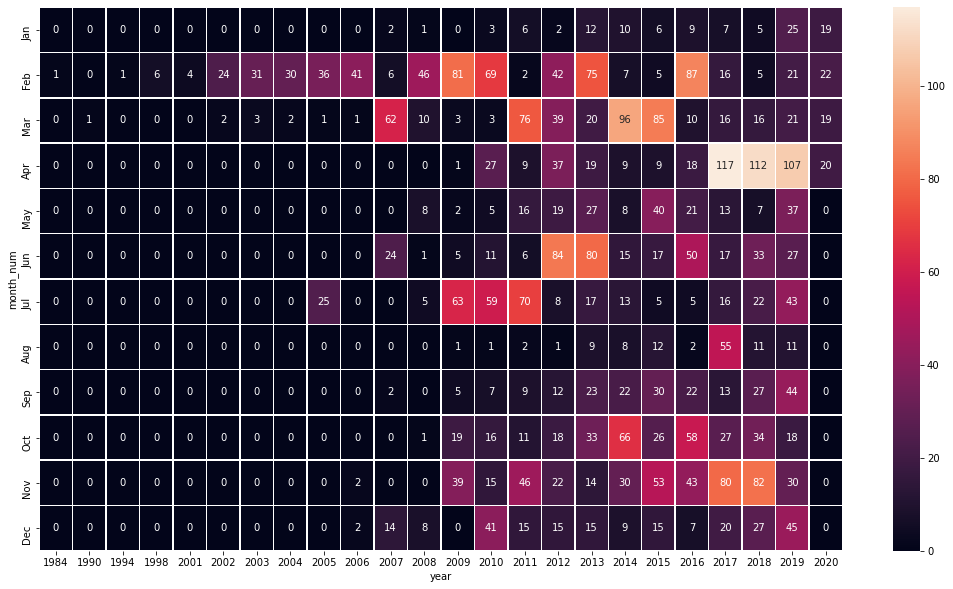

In [33]:
f, ax = plt.subplots(figsize=(18, 10))
sns.heatmap(hmap_df, annot=True, linewidths=.5, ax=ax, fmt='n', yticklabels=month_order)
plt.show()

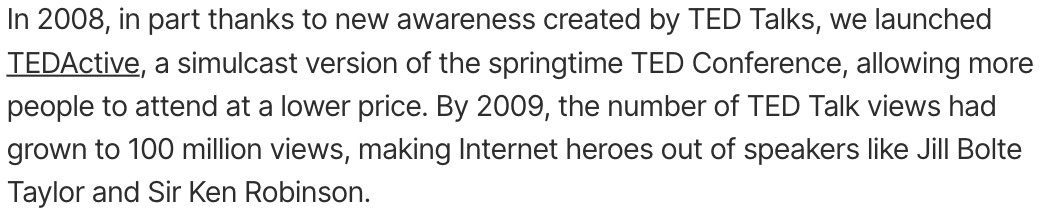
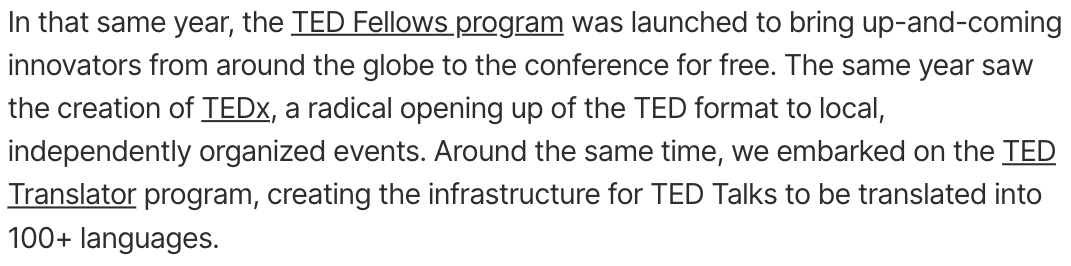

## Obvervation the overall 457 topics

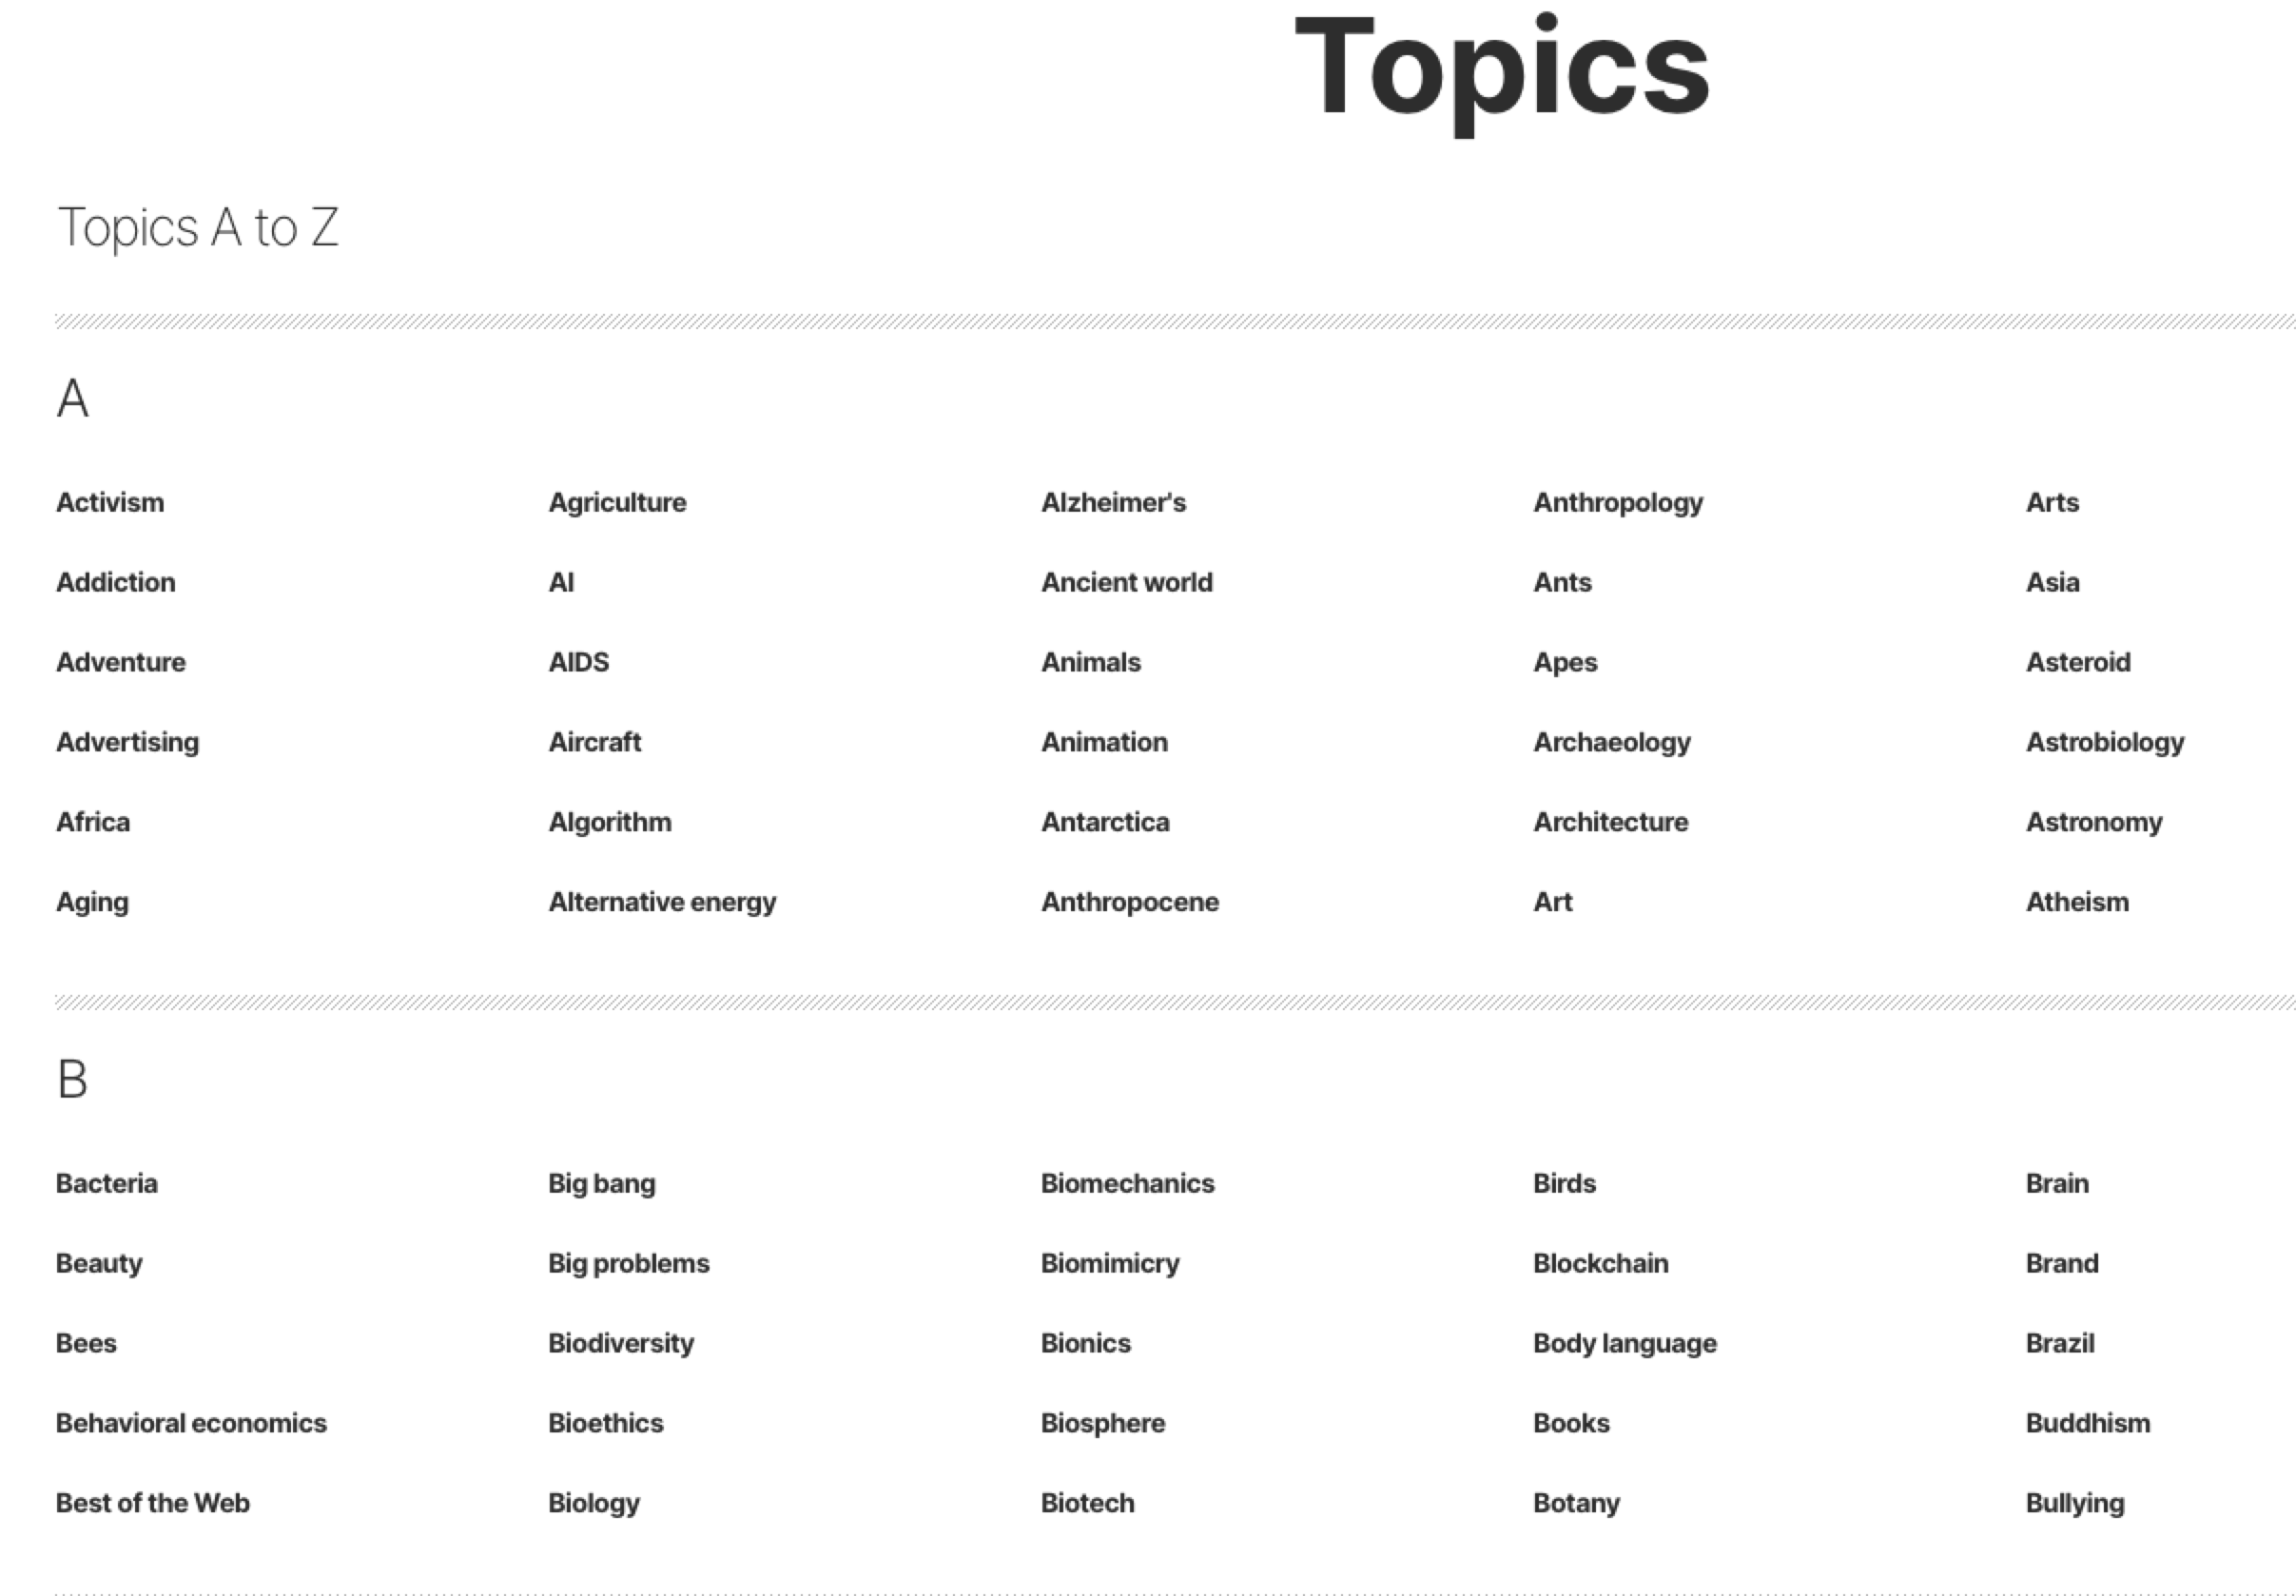

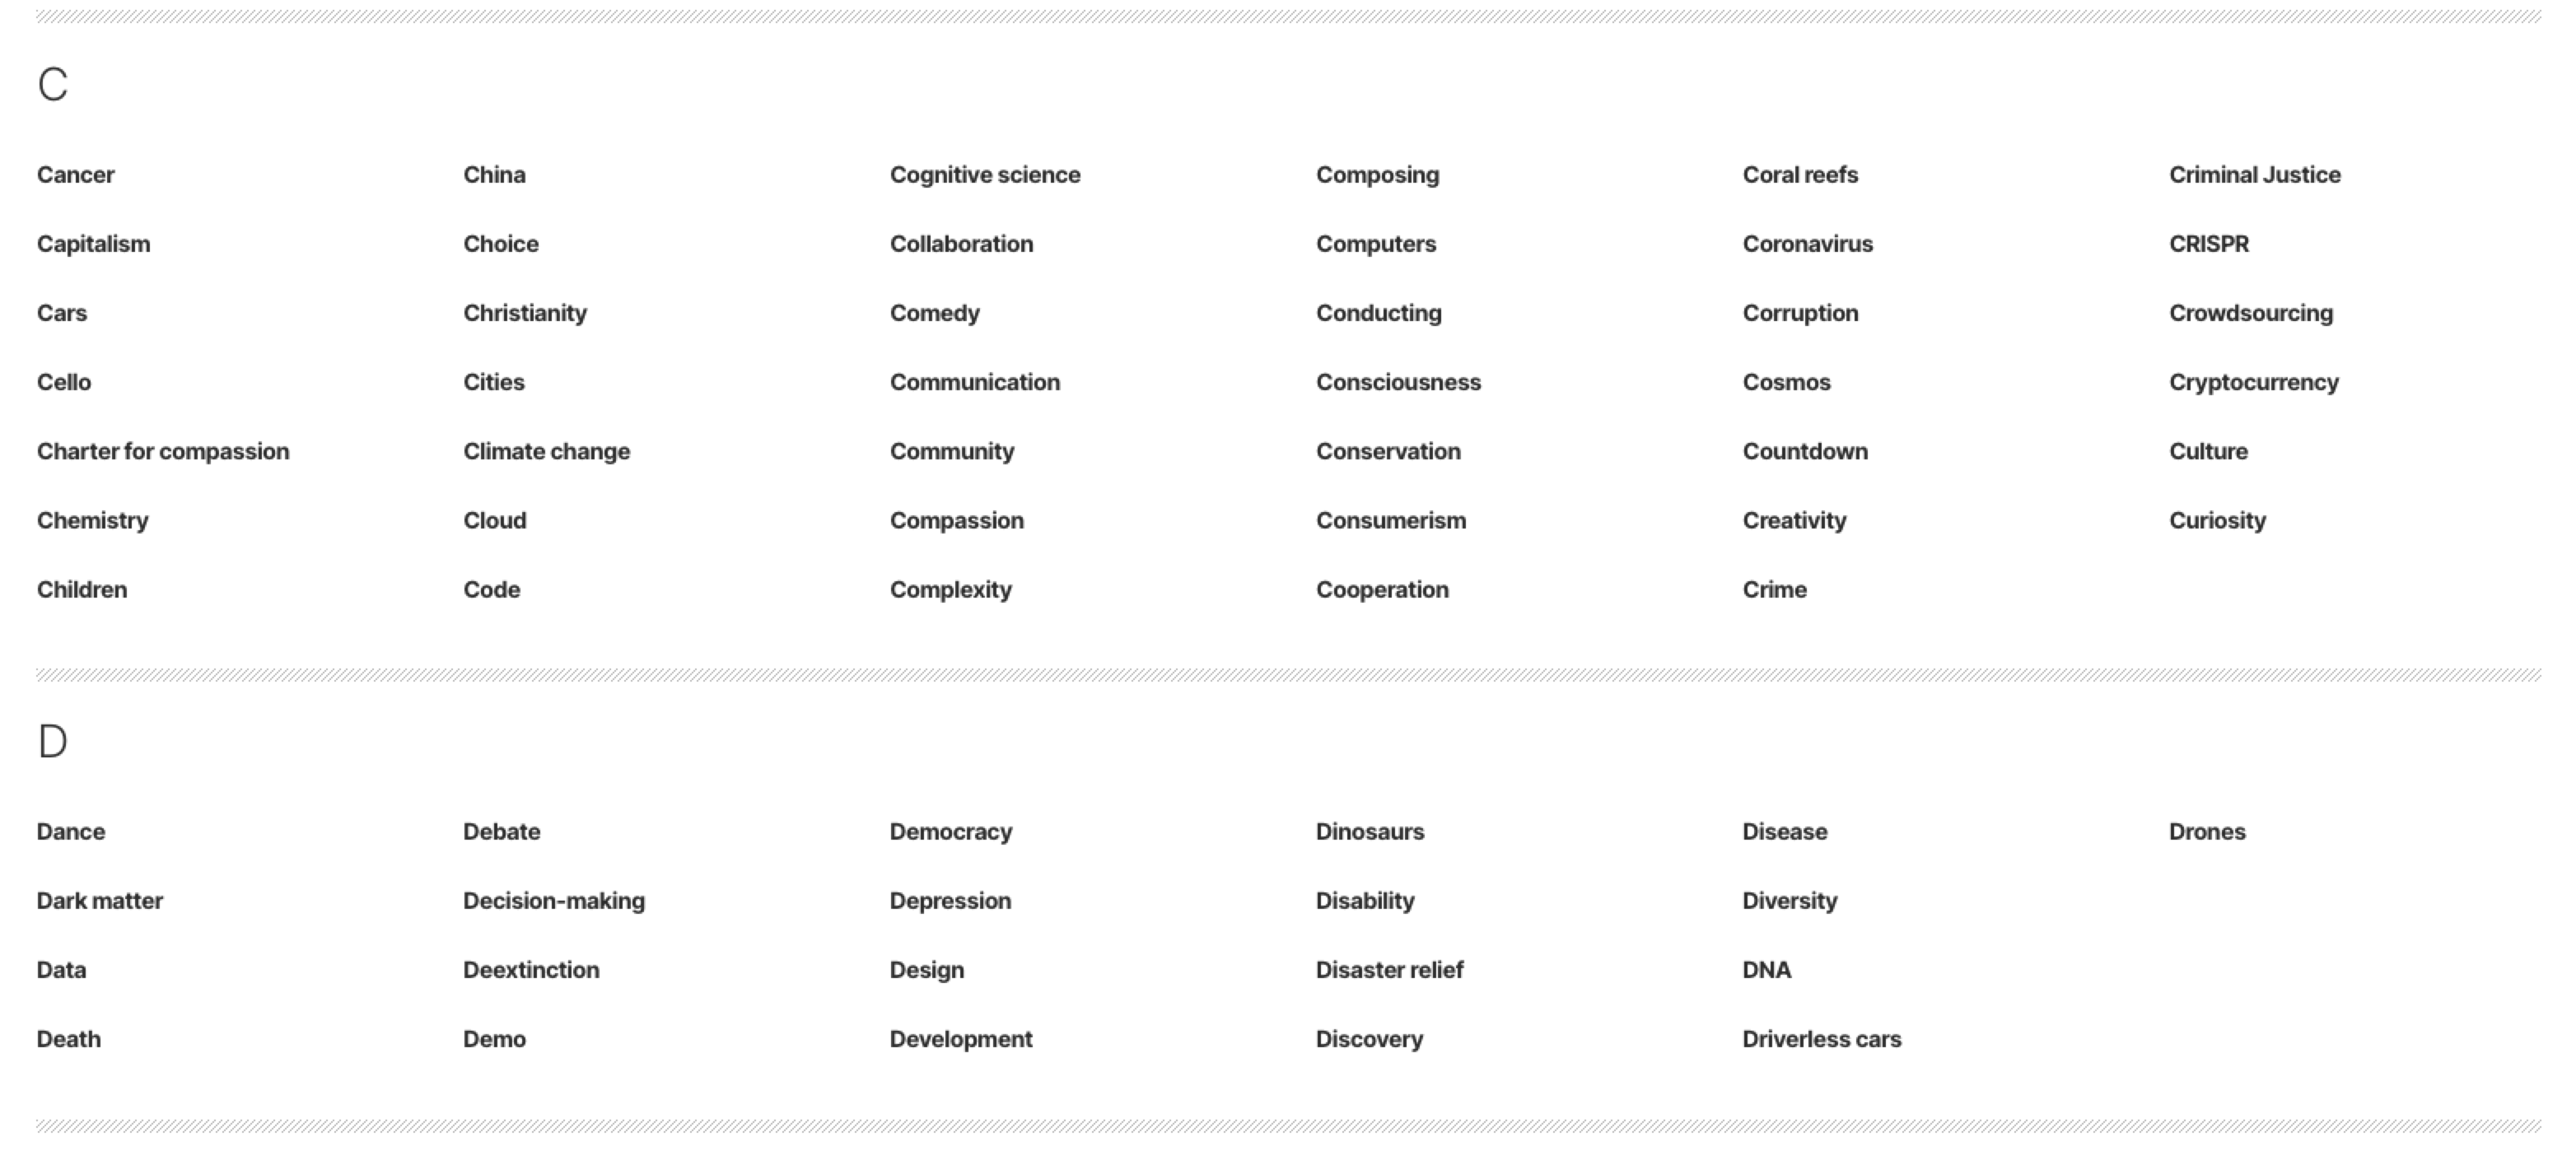

In [34]:
# transfer 'topics' from str to list
ted['topics'] = ted['topics'].apply(lambda x: ast.literal_eval(x)) 

In [35]:
ted['topics']

0       [alternative energy, cars, climate change, cul...
1       [Africa, Asia, Google, demo, economics, global...
2       [computers, entertainment, interface design, m...
3       [MacArthur grant, activism, business, cities, ...
4       [children, creativity, culture, dance, educati...
                              ...                        
4000    [activism, data, technology, mental health, so...
4001    [TED-Ed, education, history, animation, intell...
4002         [society, law, policy, justice system, TEDx]
4003    [TED-Ed, education, animation, United States, ...
4004    [animals, TED-Ed, animation, oceans, science, ...
Name: topics, Length: 4005, dtype: object

In [36]:
# unfold all the topics' tag
topics = ted.apply(lambda x: pd.Series(x['topics']),axis=1).stack().reset_index(level=1, drop=True)
topics.name = 'topics'
topics

0       alternative energy
0                     cars
0           climate change
0                  culture
0              environment
               ...        
4004                oceans
4004               science
4004             education
4004               biology
4004        climate change
Name: topics, Length: 31700, dtype: object

In [37]:
topics_df = ted.drop('topics', axis=1).join(topics)
topics_df

talk_id                                 title     speaker_1  \
0           1           Averting the climate crisis       Al Gore   
0           1           Averting the climate crisis       Al Gore   
0           1           Averting the climate crisis       Al Gore   
0           1           Averting the climate crisis       Al Gore   
0           1           Averting the climate crisis       Al Gore   
...       ...                                   ...           ...   
4004    62794  The most important anus in the ocean  Cella Wright   
4004    62794  The most important anus in the ocean  Cella Wright   
4004    62794  The most important anus in the ocean  Cella Wright   
4004    62794  The most important anus in the ocean  Cella Wright   
4004    62794  The most important anus in the ocean  Cella Wright   

             all_speakers                occupations  \
0          {0: 'Al Gore'}  {0: ['climate advocate']}   
0          {0: 'Al Gore'}  {0: ['climate advocate']}   
0          {0: 'Al Gore'}  {0: ['climate advocate']}   
0          {0: 'Al Gore'}  {0: ['climate advocate']}   
0          {0: 'Al Gore'}  {0: ['climate advocate']}   
...                   ...                        ...   
4004  {0: 'Cella Wright'}                        NaN   
4004  {0: 'Cella Wright'}                        NaN   
4004  {0: 'Cella Wright'}                        NaN   
4004  {0: 'Cella Wright'}                        NaN   
4004  {0: 'Cella Wright'}                        NaN   

                                         about_speakers    views  \
0     {0: 'Nobel Laureate Al Gore focused the world’...  3523392   
0     {0: 'Nobel Laureate Al Gore focused the world’...  3523392   
0     {0: 'Nobel Laureate Al Gore focused the world’...  3523392   
0     {0: 'Nobel Laureate Al Gore focused the world’...  3523392   
0     {0: 'Nobel Laureate Al Gore focused the world’...  3523392   
...                                                 ...      ...   
4004                                                NaN        0   
4004                                                NaN        0   
4004                                                NaN        0   
4004                                                NaN        0   
4004                                                NaN        0   

     recorded_date published_date    event native_lang  \
0       2006-02-25     2006-06-27  TED2006          en   
0       2006-02-25     2006-06-27  TED2006          en   
0       2006-02-25     2006-06-27  TED2006          en   
0       2006-02-25     2006-06-27  TED2006          en   
0       2006-02-25     2006-06-27  TED2006          en   
...            ...            ...      ...         ...   
4004    2020-04-30     2020-04-30   TED-Ed          en   
4004    2020-04-30     2020-04-30   TED-Ed          en   
4004    2020-04-30     2020-04-30   TED-Ed          en   
4004    2020-04-30     2020-04-30   TED-Ed          en   
4004    2020-04-30     2020-04-30   TED-Ed          en   

                                         available_lang  comments  \
0     ['ar', 'bg', 'cs', 'de', 'el', 'en', 'es', 'fa...     272.0   
0     ['ar', 'bg', 'cs', 'de', 'el', 'en', 'es', 'fa...     272.0   
0     ['ar', 'bg', 'cs', 'de', 'el', 'en', 'es', 'fa...     272.0   
0     ['ar', 'bg', 'cs', 'de', 'el', 'en', 'es', 'fa...     272.0   
0     ['ar', 'bg', 'cs', 'de', 'el', 'en', 'es', 'fa...     272.0   
...                                                 ...       ...   
4004                                             ['en']       NaN   
4004                                             ['en']       NaN   
4004                                             ['en']       NaN   
4004                                             ['en']       NaN   
4004                                             ['en']       NaN   

                                          related_talks  \
0     {243: 'New thinking on the climate crisis', 54...   
0     {243: 'New thinking on the climate cr

In [38]:
len(topics_df['topics'].value_counts())

457

In [39]:
pop_topics = pd.DataFrame(topics_df['topics'].value_counts()).reset_index()
pop_topics.columns = ['topics', 'talks']

In [40]:
fig = px.pie(pop_topics.head(15), values='talks', names='topics', title='Top Topics',
             width=1000, height=800)

fig.update_traces(textposition='inside', textinfo='value+label')
fig.show()

In [41]:
fig = px.pie(pop_topics, values='talks', names='topics', title='All Topics',
             width=1000, height=800)

fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

## change by year

In [42]:
topics_year = topics_df[(topics_df['topics'].isin(pop_topics.head(15)['topics'])) & (topics_df['topics'] != 'TEDx')]
topics_year['year'] = topics_year['year'].astype('int')
topics_year = topics_year[topics_year['year'] > 2002]

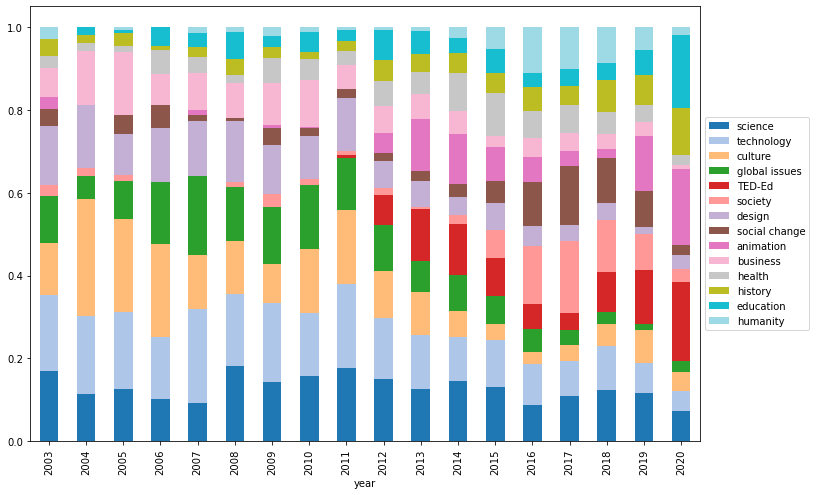

In [43]:
themes = list(pop_topics.head(15)['topics'])
themes.remove('TEDx')
ctab = pd.crosstab([topics_year['year']], topics_year['topics']).apply(lambda x: x/x.sum(), axis=1)
ctab[themes].plot(kind='bar', stacked=True, colormap='tab20', figsize=(12,8)).legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

# what do topics say

In [44]:
content = df.copy()
content.head(1)

talk_id                        title speaker_1    all_speakers  \
0        1  Averting the climate crisis   Al Gore  {0: 'Al Gore'}   

                 occupations  \
0  {0: ['climate advocate']}   

                                      about_speakers    views recorded_date  \
0  {0: 'Nobel Laureate Al Gore focused the world’...  3523392    2006-02-25   

  published_date    event native_lang  \
0     2006-06-27  TED2006          en   

                                      available_lang  comments  duration  \
0  ['ar', 'bg', 'cs', 'de', 'el', 'en', 'es', 'fa...     272.0       977   

                                              topics  \
0  ['alternative energy', 'cars', 'climate change...   

                                       related_talks  \
0  {243: 'New thinking on the climate crisis', 54...   

                                                 url  \
0  https://www.ted.com/talks/al_gore_averting_the...   

                                         description  \
0  With the same humor and humanity he exuded in ...   

                                          transcript  
0  Thank you so much, Chris. And it's truly a gre...

In [45]:
def find_topic(topic):
    has_topic = []
    for t_list in df['topics']:
        if topic.lower() in ast.literal_eval(t_list):
            has_topic.append(1)
        else:
            has_topic.append(0)
    return has_topic

In [46]:
# add columns for selected topics
content['is_science'] = find_topic('science')
content['is_business'] = find_topic('business')
content['is_psychology'] = find_topic('psychology')
content.head(1)

talk_id                        title speaker_1    all_speakers  \
0        1  Averting the climate crisis   Al Gore  {0: 'Al Gore'}   

                 occupations  \
0  {0: ['climate advocate']}   

                                      about_speakers    views recorded_date  \
0  {0: 'Nobel Laureate Al Gore focused the world’...  3523392    2006-02-25   

  published_date    event  ... comments duration  \
0     2006-06-27  TED2006  ...    272.0      977   

                                              topics  \
0  ['alternative energy', 'cars', 'climate change...   

                                       related_talks  \
0  {243: 'New thinking on the climate crisis', 54...   

                                                 url  \
0  https://www.ted.com/talks/al_gore_averting_the...   

                                         description  \
0  With the same humor and humanity he exuded in ...   

                                          transcript is_science is_business  \
0  Thank you so much, Chris. And it's truly a gre...          1           0   

   is_psychology  
0              0  

[1 rows x 22 columns]

In [47]:
content = content.loc[(content['is_science']==1) | (content['is_business']==1) | 
            (content['is_psychology']==1), : ].reset_index(drop=True)

# create new DataFrames for each topic
science = content.loc[(content['is_science']==1), 'talk_id':'transcript'].reset_index(drop=True)
business = content.loc[(content['is_business']==1), 'talk_id':'transcript'].reset_index(drop=True)
psychology = content.loc[(content['is_psychology']==1), 'talk_id':'transcript'].reset_index(drop=True)

print('science', science.shape)
print('business', business.shape)
print('psychology', psychology.shape)

science (993, 19)
business (443, 19)
psychology (211, 19)


### dataframe with all transcripts 

In [48]:
content

talk_id                                              title  \
0           1                        Averting the climate crisis   
1          53                                Greening the ghetto   
2          58                    My wish: Help me stop pandemics   
3          37                             The birth of Wikipedia   
4          25   The birth of the open-source learning revolution   
...       ...                                                ...   
1502    62341  The benefits of expressing your emotions (cons...   
1503    62270  What happens if you cut down all of a city's t...   
1504    62748       A global pandemic calls for global solutions   
1505    62782                       The dark history of IQ tests   
1506    62794               The most important anus in the ocean   

                speaker_1                                 all_speakers  \
0                 Al Gore                               {0: 'Al Gore'}   
1           Majora Carter                         {0: 'Majora Carter'}   
2         Larry Brilliant                       {0: 'Larry Brilliant'}   
3             Jimmy Wales                           {0: 'Jimmy Wales'}   
4        Richard Baraniuk                      {0: 'Richard Baraniuk'}   
...                   ...                                          ...   
1502       Artūrs Miksons                        {0: 'Artūrs Miksons'}   
1503            Stefan Al                             {0: 'Stefan Al'}   
1504      Larry Brilliant  {0: 'Larry Brilliant', 1: 'Chris Anderson'}   
1505  Stefan C Dombrowski                   {0: 'Stefan C Dombrowski'}   
1506         Cella Wright                          {0: 'Cella Wright'}   

                                            occupations  \
0                             {0: ['climate advocate']}   
1           {0: ['activist for environmental justice']}   
2             {0: ['epidemiologist', 'philanthropist']}   
3                         {0: ['founder of wikipedia']}   
4                          {0: ['education visionary']}   
...                                                 ...   
1502  {0: ['psychotherapist', 'psychosomatic psychia...   
1503                                 {0: ['architect']}   
1504  {0: ['epidemiologist', 'philanthropist'], 1: [...   
1505                                                NaN   
1506                                                NaN   

                                         about_speakers    views  \
0     {0: 'Nobel Laureate Al Gore focused the world’...  3523392   
1     {0: 'Majora Carter redefined the field of envi...  2664069   
2     {0: "TED Prize winner Larry Brilliant has spen...  1265297   
3     {0: 'With a vision for a free online encyclope...  1388802   
4     {0: 'Richard Baraniuk founded Connexions -- no...  1137837   
...                                                 ...      ...   
1502  {0: 'Arturs is a certified doctor and works at...   112898   
1503  {0: 'Architect and urban designer Stefan Al be...   329743   
1504  {0: "TED Prize winner Larry Brilliant has spen...   760969   
1505                                                NaN   307187   
1506                                                NaN        0   

     recorded_date published_date                 event  ... comments  \
0       2006-02-25     2006-06-27               TED2006  ...    272.0   
1       2006-02-26     2006-06-27               TED2006  ...    219.0   
2       2006-02-23     2006-07-25               TED2006  ...     84.0   
3       2005-07-14     2006-08-21        TEDGlobal 2005  ...     89.0   
4       2006-02-23     2006-08-21               TED2006  ...    109.0   
...            ...            ...                   ...  ...      ...   
1502    2018-11-02     2020-04-23              TEDxRiga  ...      NaN   
1503    2020-04-24     2020-04-24                TED-Ed  ...      NaN   
1504    2020-04-22     2020-04-24  TED2020: The Prequel  ...     37.0   
1505    2020-04-27     2020-04-27           

In [49]:
def combine_transcripts(transcript_list):
    corpus = ' '.join(transcript_list)
    return corpus

In [50]:
def transcripts_to_dict(df, topic_list):
    """Returns a dictionary of transcripts for each topic.
    :param df: DataFrame
    :param topic_list: List of topics
    """
    ted_dict = {}

    for topic in topic_list:
        # filter DataFrame to specific series and convert it to a list
        filter_string = 'is_' + str(topic)
        text_list = df.loc[(df[filter_string]==1), 'transcript'].to_list()

        # call combine_transcripts function to return combined text
        combined_text = combine_transcripts(text_list)

        # add combined text to dict
        ted_dict[topic] = combined_text
    return ted_dict

In [51]:
# create dictionary from the DataFrame
transcript_dict = transcripts_to_dict(content, ['science', 'business', 'psychology'])

# construct DataFrame from dictionary
transcripts3 = pd.DataFrame.from_dict(transcript_dict, orient='index')
transcripts3.rename({0: 'transcript'}, axis=1, inplace=True)

In [52]:
pd.set_option('max_colwidth',500)
transcripts3

transcript
science     Thank you so much, Chris. And it's truly a great honor to have the opportunity to come to this stage twice; I'm extremely grateful. I have been blown away by this conference, and I want to thank all of you for the many nice comments about what I had to say the other night. And I say that sincerely, partly because (Mock sob) I need that. (Laughter) Put yourselves in my position. (Laughter) I flew on Air Force Two for eight years. (Laughter) Now I have to take off my shoes or boots to get on a...
business    If you're here today — and I'm very happy that you are — you've all heard about how sustainable development will save us from ourselves. However, when we're not at TED, we are often told that a real sustainability policy agenda is just not feasible, especially in large urban areas like New York City. And that's because most people with decision-making powers, in both the public and the private sector, really don't feel as though they're in danger. The reason why I'm here today, in part, is b...
psychology  I'd like to talk today about the two biggest social trends in the coming century, and perhaps in the next 10,000 years. But I want to start with my work on romantic love, because that's my most recent work. What I and my colleagues did was put 32 people, who were madly in love, into a functional MRI brain scanner. 17 who were madly in love and their love was accepted; and 15 who were madly in love and they had just been dumped. And so I want to tell you about that first, and then go on into ...

In [53]:
pd.set_option('max_colwidth',50)

### Corpora

In [54]:
corpus1 = ' '.join(transcripts3.loc['science'])
corpus2 = ' '.join(transcripts3.loc['business'])
corpus3 = ' '.join(transcripts3.loc['psychology'])
#corpus3

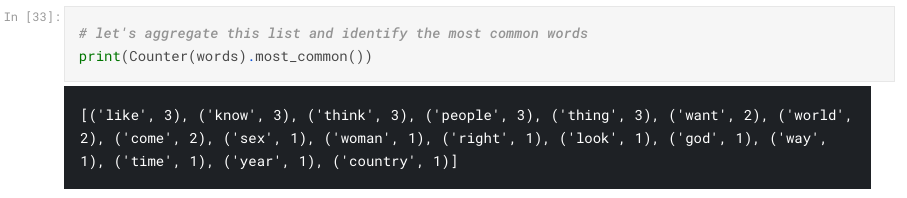

In [55]:
# add custom stop words
custom_stop_words = {
    'know','think','people','thing','things','something','want','world','come',
    'one','see','now','going','way','u','much','laughter','say','said','us','really','actually',
    'make','will','well'
}

In [56]:
STOPWORDS_new = STOPWORDS | custom_stop_words

# Word Cloud

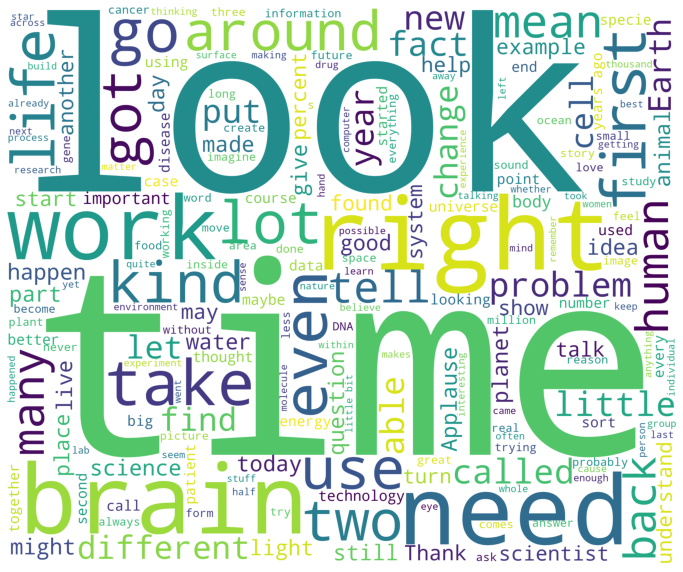

In [57]:
wordcloud = WordCloud(stopwords=STOPWORDS_new, background_color='white',width=2400,height=2000).generate(corpus1)
plt.figure(figsize=(12,15))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

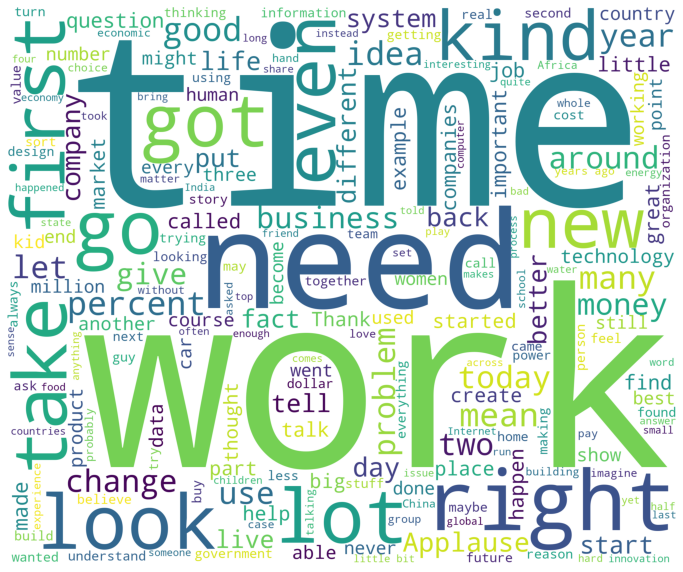

In [58]:
wordcloud = WordCloud(stopwords=STOPWORDS_new, background_color='white',width=2400,height=2000).generate(corpus2)
plt.figure(figsize=(12,15))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

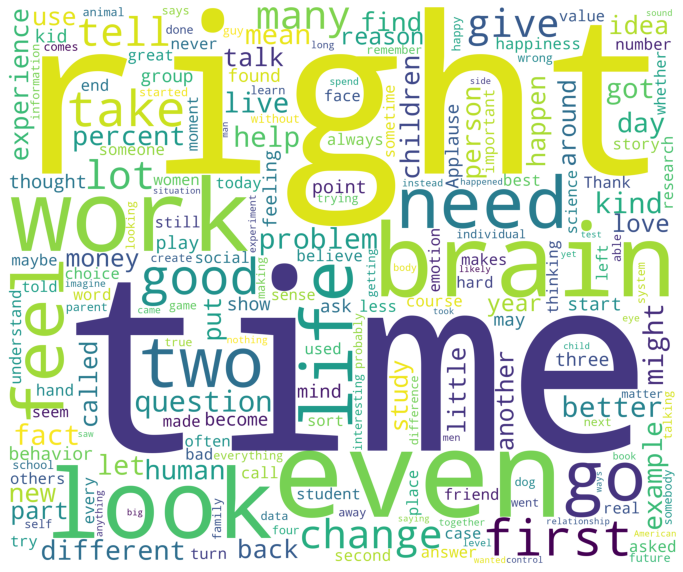

In [59]:
wordcloud = WordCloud(stopwords=STOPWORDS_new, background_color='white',width=2400,height=2000).generate(corpus3)
plt.figure(figsize=(12,15))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

# recommendation system

In [60]:
rec = ted[['title','description']]
rec

title  \
0                          Averting the climate crisis   
1                      The best stats you've ever seen   
2                                     Simplicity sells   
3                                  Greening the ghetto   
4                          Do schools kill creativity?   
...                                                ...   
4000       Crisis support for the world, one text away   
4001                      The dark history of IQ tests   
4002  How "policing for profit" undermines your rights   
4003      The electrifying speeches of Sojourner Truth   
4004              The most important anus in the ocean   

                                            description  
0     With the same humor and humanity he exuded in ...  
1     You've never seen data presented like this. Wi...  
2     New York Times columnist David Pogue takes aim...  
3     In an emotionally charged talk, MacArthur-winn...  
4     Sir Ken Robinson makes an entertaining and pro...  
...                                                 ...  
4000  What if we could help people in crisis anytime...  
4001  In 1905, psychologists Alfred Binet and Théodo...  
4002  Many countries have an active, centuries-old l...  
4003  Isabella Baumfree was born into slavery in lat...  
4004  Is it a fuzzy sock? An overripe banana? A mold...  

[4005 rows x 2 columns]

In [63]:
# Transforms text to feature vectors
Text=rec['description'].tolist()
tfidf=text.TfidfVectorizer(input=Text,stop_words="english")
matrix=tfidf.fit_transform(Text)
print(matrix.shape)

(4005, 21082)


In [64]:
# Get Similarity Scores using cosine similarity
cosine_sim=cosine_similarity(matrix)
print(cosine_sim)

[[1.         0.         0.01053605 ... 0.         0.03145201 0.        ]
 [0.         1.         0.         ... 0.         0.         0.        ]
 [0.01053605 0.         1.         ... 0.01588319 0.03110523 0.        ]
 ...
 [0.         0.         0.01588319 ... 1.         0.         0.        ]
 [0.03145201 0.         0.03110523 ... 0.         1.         0.01424151]
 [0.         0.         0.         ... 0.         0.01424151 1.        ]]


In [65]:
indices = pd.Series(rec['title'])
def recommend_talks(name):
    talks=[]
    idx = indices[indices == name].index[0]
    sort_index = pd.Series(cosine_sim[idx]).sort_values(ascending = False)
    top_10 = sort_index.iloc[1:11]
    for i in top_10.index:
        talks.append(indices[i])
    print(*talks, sep='\n')

In [66]:
def rec():
    try:
        i = 1
        while(i > 0):
            name = input("\n Enter The title of the TED Talk : ")
            if name.lower() == 'quit':
                break
            else:
                print("\n",recommend_talks(name))
    except KeyboardInterrupt:
        print("The TED Talk does not exist\n")
        rec()
    except IndexError:
        print("The TED Talk does not exist\n")
        rec()
print("To exit Enter \"quit\" \n")
rec()

To exit Enter "quit" 


 Enter The title of the TED Talk : The happy secret to better work
Plug into your hard-wired happiness
The first secret of design is ... noticing
Helping others makes us happier -- but it matters how we do it
Want to be happier? Stay in the moment
The surprising science of happiness
What do we do with all this big data?
The paradox of efficiency
7 rules for making more happiness
How to get better at the things you care about
The Happy Planet Index

 None

 Enter The title of the TED Talk : The power of vulnerability
Listening to shame
Falling in love is the easy part
How couples can sustain a strong sexual connection for a lifetime
Connected, but alone?
A radical experiment in empathy
Scenes from "My Architect"
Our antisocial phone tricks
What gardening taught me about life
Beware conflicts of interest
The difference between healthy and unhealthy love

 None

 Enter The title of the TED Talk : quit


1. The happy secret to better work
2. The power of vulnerability

# Overall Conclusion and Extrapolating Prediction

- __1.
Top videos have more than 3M views and 10k comments.The audience would like to talk more about religion, politics topics.__     


- __2.
develpment with years, especially after 2009.__ 


- __3.
There are 457 topics and very diverse. most involved topics are science, technology, global, education.There are waves, but these topics keep.__   


- __4.
Science talks more about "time, brain, universe ...", business talks more about "money, product, innovation ...", psychology talks more about "time, relationship, happiness ..."__  


- __5.
A text-based recommendation system is built, and related talks with similar topics could be recommended.__

# References


https://www.ted.com/about/our-organization/history-of-ted

https://www.kaggle.com/miguelcorraljr/ted-ultimate-dataset